In [1]:
import warnings
from pylj import md, sample, force, util, em
import numpy as np

warnings.filterwarnings('ignore')

## Investigation of the ideal gas law

Molecular dynamics is a powerful method for exploring the structure of solids, liquids, and gases. The idea is simple: calculate the forces acting on the atoms in a system and anlayse their time-dependent behaviour and motion using Newtonian mechanics. When eneroguh information on the motion of the individual particles has been gathered, it is possible to deduce properties of the system. 

The aim of this exercise to use molecular dynamics simulation to investigate the nautre of an ideal gas. This involves the 2-dimensional simulation of an argon gas analogue using [pylj](pythoninchemistry.org/pylj). The function defined below is a typical molecular dynamics simulation where the number of particles, volume of the system, and system temperature are kept constant (this is referred to as the NVT ensemble). 

In [2]:
def md_simulation(number_of_particles, temperature, number_of_steps, sample_frequency):
    # Creates the visualisation environment
    %matplotlib notebook
    # Initialise the system
    particles, system = md.initialise(number_of_particles, temperature, 0.01, util.set_particles_square)
    # This sets the sampling class
    sample_system = sample.Interactions(system)
    # Start at time 0
    system.time = 0
    # Begin the molecular dynamics loop
    for i in range(0, number_of_steps):
        # At each step, calculate the forces on each particle 
        # and get acceleration
        particles, system = force.compute_forces(particles, system)
        # Run the equations of motion integrator algorithm
        particles, system = md.velocity_verlet(particles, system)
        # Allow the system to interact with a heat bath
        particles = force.heat_bath(particles, system)
        # Iterate the time
        system.time += system.timestep_length
        # At a given frequency sample the positions and plot the RDF
        if system.step % sample_frequency == 0:
            sample_system.update(particles, system)
    return system

This simulation could be run for 10 particles over 1000 steps, with a temperature of 1 using the following command. Note that the temperature and pressure are all in arbitrary units. 

<IPython.core.display.Javascript object>


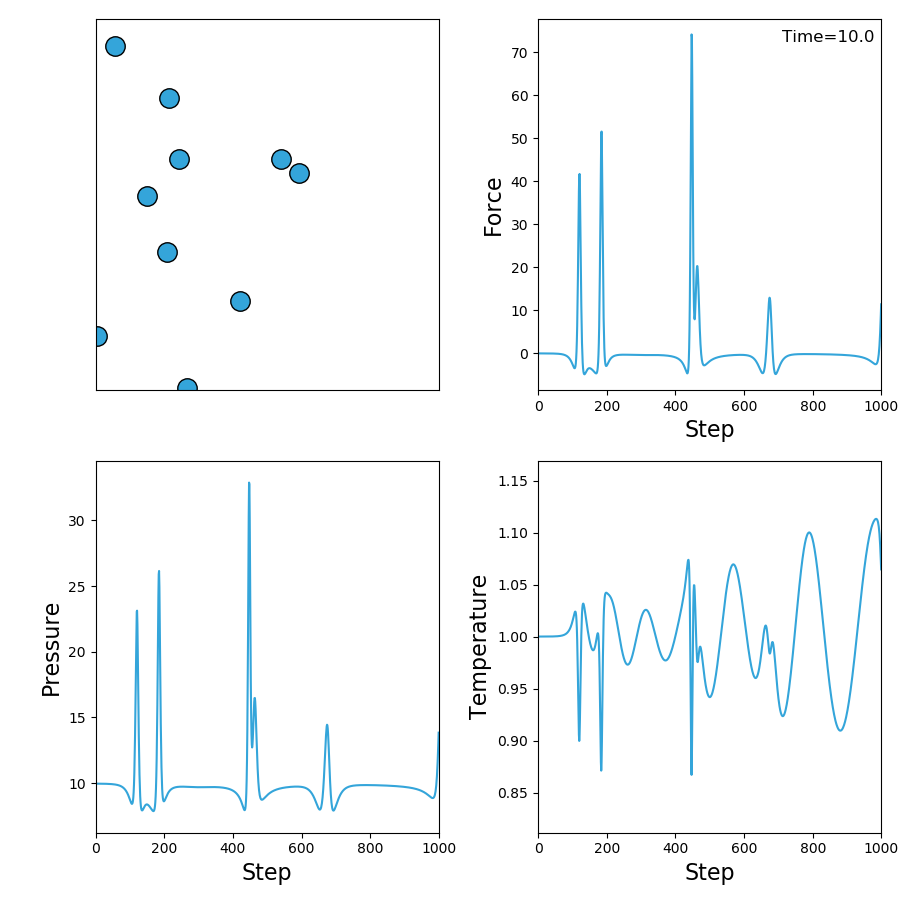

In [3]:
system = md_simulation(10, 1, 1000, 10)

We are wanting to investigate the nature of the gas ideality, therefore we are considering the following relationship

$$ p = \frac{nRT}{V}, $$

where pressure, $p$, is the observable as it is given as an output plot by pylj and any of $n$, $T$, or $V$ can be varied to investigate this relationship. However, in pylj the system area (as it is 2D) is constrained to be $16^2$. This limited us to varying the number of particles, or the temperature. 

It is possible to return the average pressure during the entire simulation using the following command. 

In [6]:
print("Average pressure = {:.2f}+/-{:.2f}".format(system.pressure.mean(), system.pressure.std()))

Average pressure = 10.03+/-2.55


Therefore, hopefully it is evident how pylj could be used, along with a for loop to study the increase number of particles. 

<IPython.core.display.Javascript object>


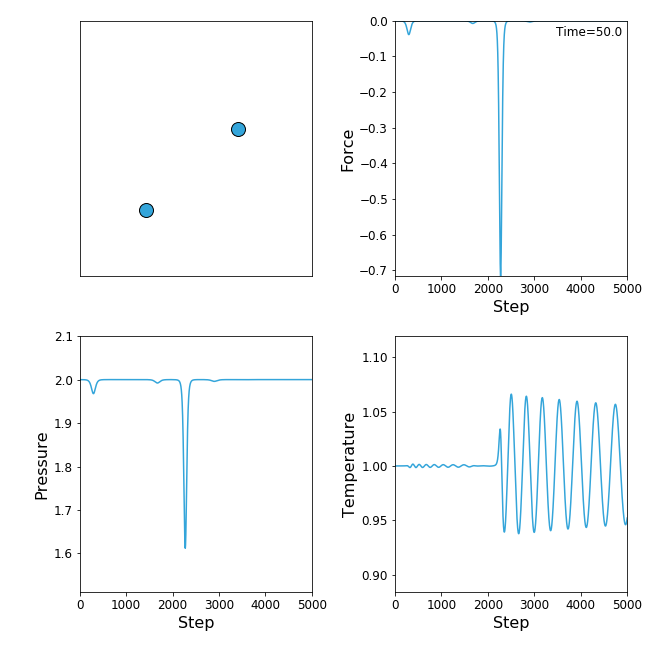

<IPython.core.display.Javascript object>


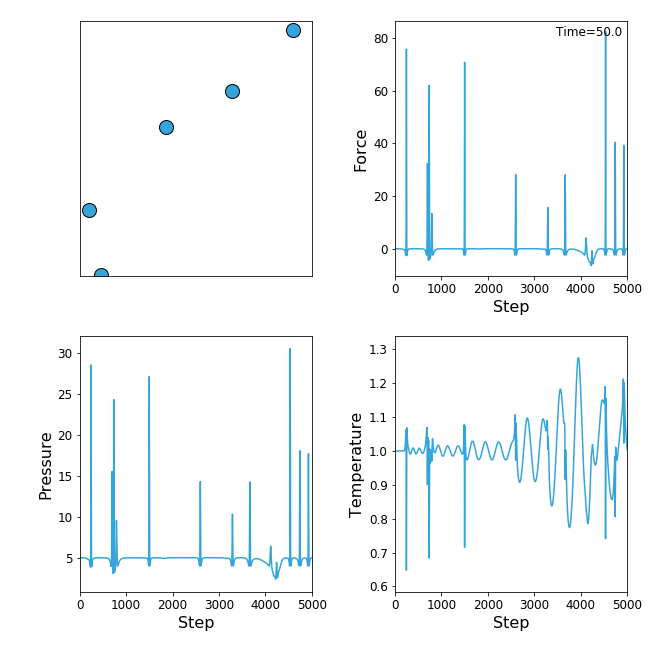

<IPython.core.display.Javascript object>


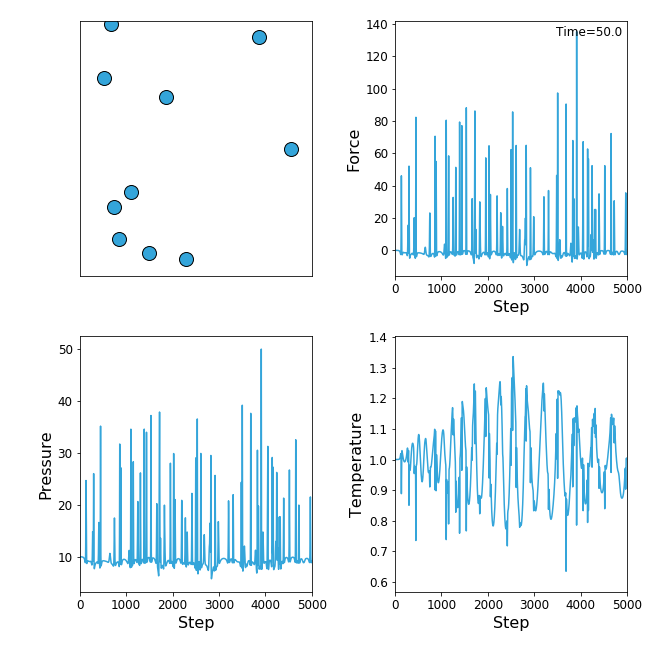

<IPython.core.display.Javascript object>


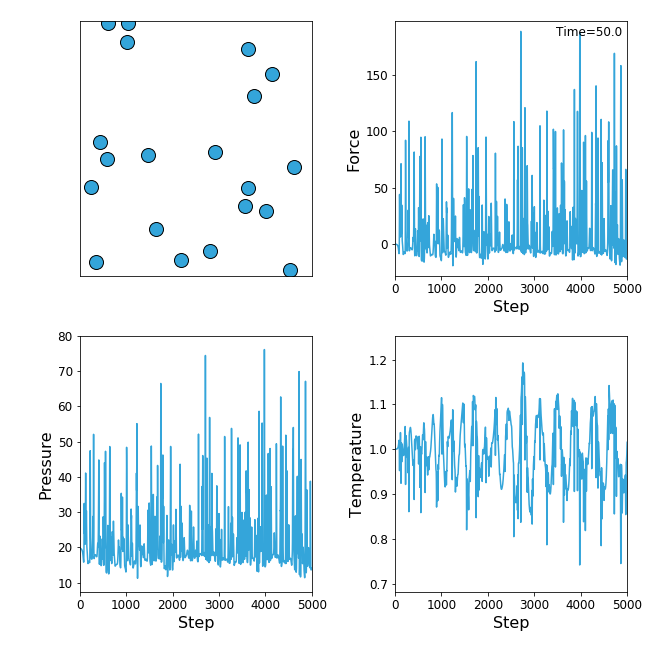

<IPython.core.display.Javascript object>


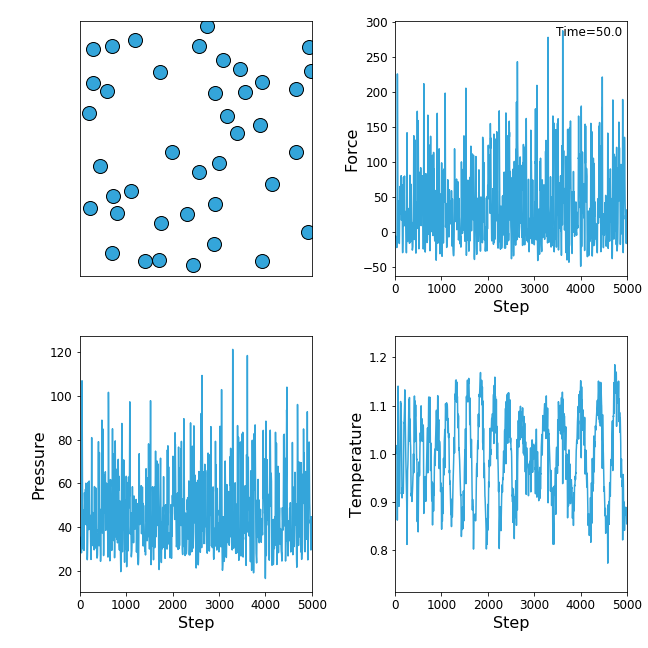

<IPython.core.display.Javascript object>


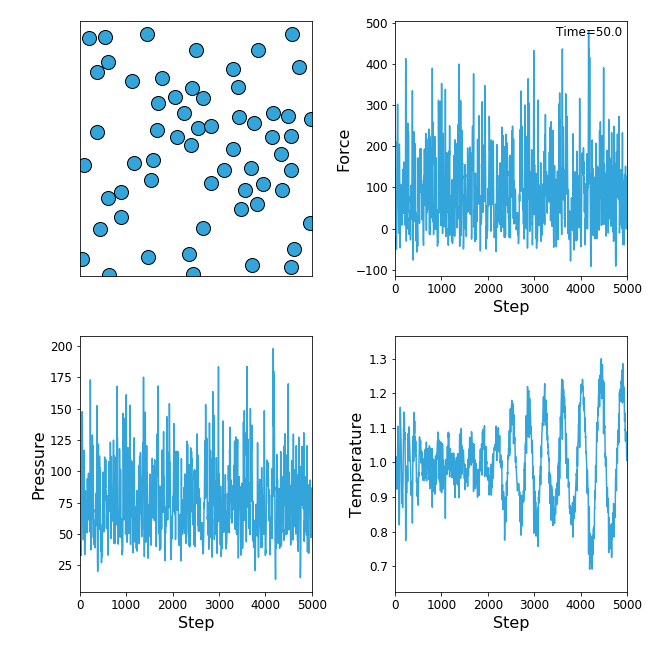

<IPython.core.display.Javascript object>


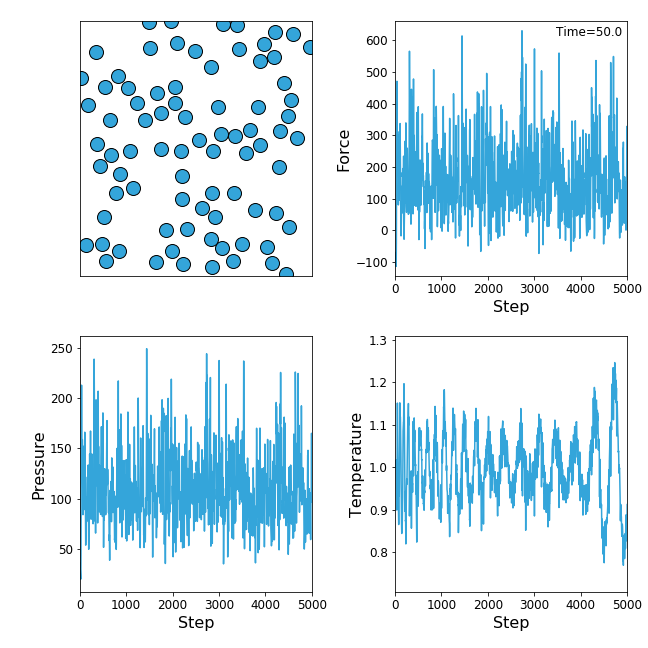

<IPython.core.display.Javascript object>


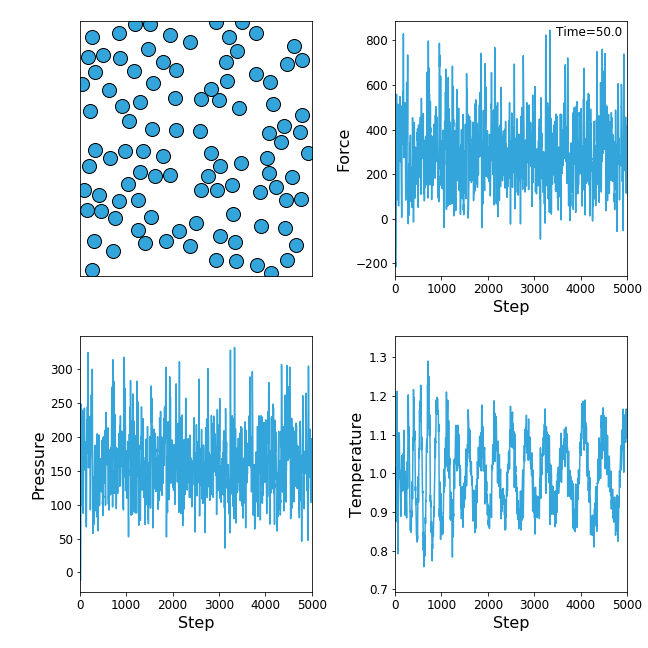

<IPython.core.display.Javascript object>


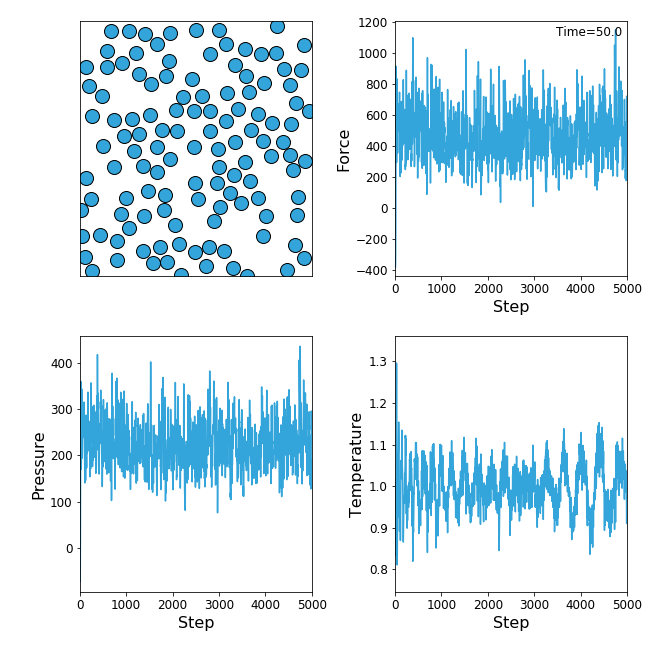

In [15]:
numb_parts = np.array([2, 5, 10, 20, 40, 60, 80, 100, 120])
pressure = np.zeros_like(numb_parts)
pressure_std = np.zeros_like(numb_parts)
for i in range(0, len(numb_parts)):
    system = md_simulation(numb_parts[i], 1, 5000, 10)
    pressure[i] = system.pressure.mean()
    pressure_std[i] = system.pressure.std()

It is then possible to plot the pressure against the number of particle in each simulation. The straight line of the ideal gas law can also be included, in the internal units of pylj the ideal gas constant has the following value.

$$ R = 256 $$

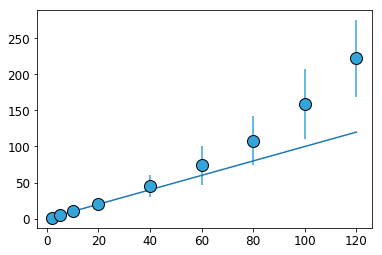

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['font.size']=16
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

plt.errorbar(numb_parts, pressure, marker='o', yerr=pressure_std, 
             ls='', color='#34a5daff', markeredgecolor='black', markersize=12)
plt.plot(numb_parts, 256 * 1 / 16 ** 2 * numb_parts, color='#34a5daff')
plt.show()

The deviation from the ideal gas law is clear. The student could be asked to comment on the deviation. 

The van der Waals' equation includes corrections associated with the interactions between atoms, and has the form

$$ p = \frac{nRT}{V-nb} - a\frac{n^2}{V^2}, $$

where $a$ and $b$ are the corrections. We can used scipy.optimize to fit values of $a$ and $b$ for our system.

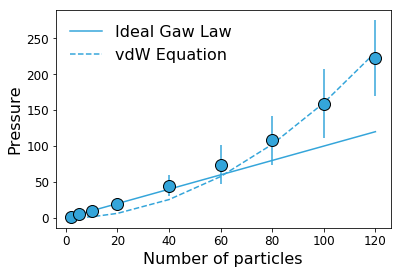

a = -1048.82 and b = 237484.32


In [25]:
from scipy.optimize import curve_fit

def vdW(x, a, b):
    return (1. / 256. * x) / (16. ** 2. - x * b) - (a * (x ** 2.) / (16. ** 2. ** 2.))

ab = curve_fit(vdW, numb_parts, pressure)
a = ab[0][0]
b = ab[0][1]

plt.errorbar(numb_parts, pressure, marker='o', yerr=pressure_std, 
             ls='', color='#34a5daff', markeredgecolor='black', markersize=12)
plt.plot(numb_parts, 256 * 1 / 16 ** 2 * numb_parts, color='#34a5daff', label='Ideal Gaw Law', ls = '-')
plt.plot(numb_parts, vdW(numb_parts, a, b), color='#34a5daff', label='vdW Equation', ls = '--')

plt.xlabel('Number of particles')
plt.ylabel('Pressure')
plt.legend(frameon=False)
plt.show()
print("a = {:.2f} and b = {:.2f}".format(a, b))